# 第一部分：Quantum Monte Carlo在量子光学体系的应用
1. Quantum Monte-Carlo 方法概述
2. Leaking Cavity
3. Light-coupled two-level system with dissipation（含光耦合的耗散二能级系统）
4. 和Master Equation方法的对比

## Quantum Monte-Carlo 方法概述
我们在课上做的多是粒子空间轨迹的Monte Carlo模拟，而此处我们模拟的最大不同是，这里并不是空间轨迹，而是“量子态轨迹”。“量子态轨迹”具体的演化方式和初态以及哈密顿量具体形式有关，当我们用来描述与环境相互作用的Markov过程时，我们会给哈密顿量引入非厄密项，而正是这一项让我们需要用Monte Carlo方法来解决问题。下面是概述：

密度矩阵描述了量子系综（许多相同物理系统）上的总体平均，而蒙特卡洛（Monte Carlo）也就是波动函数演化的Quantum jump方法则允许模拟系统动力学的单个物理系统。 如果环境对系统不断扰动，从而导致系统波函数发生一系列量子跃迁，最终通过环境测量获得的有关系统状态的信息增加。通常这种演化受具有非厄密有效哈密顿量的薛定谔方程控制。
$$H_{eff}=H_{sys}-\frac{i\hbar}{2}\sum_nC^\dagger_nC_n$$
同样，$C_n$是湮灭算子，每个算子对应于一个单独的不可逆过程，其速率为$\gamma_n$. 此方程的前半部分是厄密的，而后半部分是非厄密的，非厄密的结果是耗散的产生，正好可以来描述有环境参与相互作用的系统。这个方法与主方程（Master Equation）的方法等价。他导致波动函数范数的减少，即在短时间内$\delta_t$后方程的归一化变为$\langle\phi(t+\delta_t)|\phi(t+\delta_t)\rangle=1-\delta p$，其中
$$\delta p=\delta_t\sum_n\langle\phi(t)|C^\dagger_nC_n|\phi(t)\rangle$$
由于概率守恒，另一部分概率作为系统的decay过程进入到环境里，此时$|\phi_\alpha\rangle$坍缩成$|\phi_K\rangle$.

所以对于我们的计算而言，如果$r>\delta p$，把$|\phi_\alpha\rangle$做短时间的演化得到$(1-i\delta_t\hat{H}/\hbar)|\phi_\alpha\rangle/\sqrt{1-\delta p}$；如果$\sum_{k=1}^{K}\delta p_k < r < sum_{k=1}^{K+1}\delta p_k$，则$|\phi_\alpha\rangle$坍缩成$|\phi_K\rangle$.

##### 下面是我们的计算过程
1. 选定一个初态$|\phi_\alpha\rangle$
2. 选定一个随机数r
3. 对一个合适的时间间隔$\delta_t$，计算$\delta p$，如果$r>\delta p$，把$|\phi_\alpha\rangle$换成$(1-i\delta_t\hat{H}/\hbar)|\phi_\alpha\rangle/\sqrt{1-\delta p}$；如果$\sum_{k=1}^{K}\delta p_k < r < sum_{k=1}^{K+1}\delta p_k$，则$|\phi_\alpha\rangle$坍缩成$|\phi_K\rangle$.
4. 重复2，3则可以通过Monte-Carlo方法得到一个粒子的演化轨迹
5. 重复1-4可以得到N个粒子轨迹，我们可以通过这些粒子算分布，当然也可以取平均看系统的宏观演化情况。

## Leaking Cavity

模拟情况说明：通过量子光学的知识我们知道，如果形式化计算optical cavity里的光场，实际上是解一个无穷维的矩阵的问题，然而处理那种问题会给计算机的带来很多麻烦。通常情况下，人们一般取比较大的有限维矩阵来近似模拟这个体系，但解一个$100000\times100000$的矩阵对计算机而言也不是一件小事。我的朋友Yesun发明了一种簇类分解的办法，可以在低耦合系统中避免这个问题，从而获得更快速的解。而这里，为简便起见我进行两个假设，来处理这个模型：

1. optical cavity的环境是T=0K的真空热光场
2. 初态光场的光子数较多

处理的方法如下:

我们取初态波函数是$|\phi>=|n_0>$，进行耗散速率$\gamma = 0.005$,每一步之间的时间间隔$delta_t = 0.1$。则每一步耗散一个光子给光场的概率为：$$\delta_p = \delta_t\gamma\langle\phi| a^\dagger a|\phi\rangle=\delta_t\gamma n$$其中n是此时光场的光子数。如果$r>\delta_p$，把$|n\rangle$换成$|n\rangle$；如果$r<\delta_p$，则$|n\rangle$坍缩成$|n-1\rangle$.

``` cpp
#include<iostream>
#include <time.h>

//经典的16807随机数产生器
#define M_16807 2147483647 
#define A_16807 16807	
#define R_16807 2836
#define Q_16807 127773

using namespace std;


int Schrage_int(int seed)	//定义Schrage迭代产生随机数的方法，输入一个种子值，即可输出一个对应整数
{
	if (seed < 0)
	{
		return -1;	//错误返回-1
	}

	int z = A_16807 * (seed % Q_16807) - R_16807 * (seed / Q_16807);	//计算Shrage

	if (z < 0)		//判断正负,从而决定如何输出
	{
		return z + M_16807;
	}
	else
	{
		return z;
	}
}


int Seed()	//ͨ搞出来一个种子值
{
	time_t rawtime;
	int seed;
	struct tm* info;	//获取
	time(&rawtime);
	info = localtime(&rawtime);	//当地时间
	info->tm_year = info->tm_year % 100;

	seed = info->tm_year + 70 * (info->tm_min + 12 * (info->tm_mday\
		+ 31 * (info->tm_hour + 23 * (info->tm_min + 59 * (info->tm_sec)))));	//计算种子
	return seed;
}

void DampingField()  //计算量子蒙卡结果的函数
{
    //波函数是|phi>=|n0>
    int n0 = 100;
 
    int n = 0;  //定义迭代量n
    float Gamma = 0.005;  //哈密顿量非厄密部分的耗散速率
    float delta_t = 0.1;    //每一步之间的时间间隔
    int M = 10000;   //单个粒子Monte Carlo进行的步数，此处固定为10000
    int K = 1000;   //总共模拟的粒子数
    int z = Seed();  //种子值
    float N[10000] = {0}; //用来记录各个时刻腔内的光子数


    //下面定义非厄密演化的耗散概率delta_p，和随机数，以及演化过程中的归一化因子
    float delta_p = 0;
    float rand = ((float)z / M_16807);  //使用Schrage随机数产生器来产生随机数


    for (int j = 0; j < K; j++) //这个循环是对K个粒子取平均（这一步先求和，下面再除N）
    {
        n = n0; //将迭代量初始化
        N[0] += n;  //让数组记录下初始的N值

        for (int i = 1; i < M; i++) //这个循环是对单个粒子进行M步的Monte Carlo行走
        {

            z = Schrage_int(z);
            rand = ((float)z / M_16807);    //产生随机数
            delta_p = Gamma * delta_t * n;  //计算delta_p
            if (delta_p < rand) //进行条件判断，如果成立，就进行幺正演化，如果不成立，就会有耗散项
            {
                n = n;
            }
            else
            {
                n = n - 1;
            }
            if ( n < 0 ) //这一项保证腔内光子数只能为正
            {
                n = 0;
            }
            N[i] += n;
        }
    }

    for (int i = 0; i < M; i++) //对K个M步粒子取平均
    {
        N[i] = ((float)N[i]/K);
    }
    

    //到此为止，N[i]这个数组，就是各阶段腔内光子数分布了，接下来我们把它写入文件    
	FILE* fp = NULL; //文件指针
    fp = fopen("Results.txt", "w"); //打开文件
    for (int i = 0; i < M; i++)
    {
        fprintf(fp,"%f\n",N[i]);
    }
    fclose(fp); //关闭文件
}

int main()
{
    DampingField();  //调用TwoLevelSys函数
}
```

我们假设$n_0 = 100$, $\gamma = 0.005$,$delta_t = 0.1$,单个粒子的模拟步数$M = 10000$,总共模拟的粒子数$K = 1000$. 下面是我们模拟的结果，并与理论值对比. 

Text(0.5, 1.0, 'Simulation of Leaking Cavity')

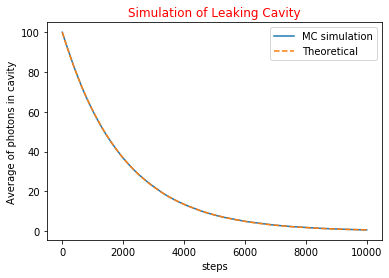

In [1]:
import numpy as np
import matplotlib.pyplot as plt

p = open("1.txt")

s = [float(i) for i in p]

x = np.arange(10000)

y = 100*np.exp(-0.005*x*0.1)

plt.plot(x,s,label = "MC simulation")
plt.plot(x,y,linestyle='--', label = "Theoretical")
plt.legend(loc = "best")
plt.xlabel("steps")
plt.ylabel("Average of photons in cavity")
plt.title("Simulation of Leaking Cavity",c ="r")

可以看到，模拟结果与理论完全相符！

## Light-coupled two-level system with dissipation （含光耦合的耗散二能级系统）

这个情况比上面耗散腔要复杂很多，因为要引入薛定谔方程的演化，然而这种演化一般情况是复数，所以维度一旦上升，处理起来极其麻烦，好在我们研究的是二能级系统，自由度较少，也免去了解巨型矩阵的繁琐。

对这个模型，处理的方法如下:

我们取初态波函数是$|\phi>=a|down>+b|up>$，进行不同光泵浦$\Omega$和耗散速率$\gamma$的演化,每一步之间的时间间隔$delta_t = 0.03$。则每一步直接塌缩到$|down>$的几率为：$$\delta_p = \delta_t\gamma\langle\phi| a^\dagger a|\phi\rangle=\delta_t\gamma |b|^2$$其中$|b|^2$是此时原子上能级的布局数。如果$r>\delta_p$，则哈密顿量正常演化；如果$r<\delta_p$，则$|\phi\rangle$直接坍缩成$|down\rangle$

``` cpp
#include<iostream>
#include<complex>
#include<complex.h>
#include <time.h>

//经典的16807随机数产生器
#define M_16807 2147483647 
#define A_16807 16807	
#define R_16807 2836
#define Q_16807 127773

using namespace std;


int Schrage_int(int seed)	//定义Schrage迭代产生随机数的方法
{
	if (seed < 0)
	{
		return -1;	//错误返回-1
	}

	int z = A_16807 * (seed % Q_16807) - R_16807 * (seed / Q_16807);	//计算Shrage

	if (z < 0)		//判断正负,从而决定如何输出
	{
		return z + M_16807;
	}
	else
	{
		return z;
	}
}


int Seed()	//ͨ搞出来一个种子值
{
	time_t rawtime;
	int seed;
	struct tm* info;	//获取
	time(&rawtime);
	info = localtime(&rawtime);	//当地时间
	info->tm_year = info->tm_year % 100;

	seed = info->tm_year + 70 * (info->tm_min + 12 * (info->tm_mday\
		+ 31 * (info->tm_hour + 23 * (info->tm_min + 59 * (info->tm_sec)))));	//计算种子
	return seed;
}

void TwoLevelSys()  //计算量子蒙卡结果的函数
{
    //波函数是|phi>=a|down>+b|up>
    float a0 = 0;   //下态的初始系数
    float b0 = 1;   //上态的初始系数
    complex<double> Omega = 0; //哈密顿量的厄密部分的演化速率
    complex<double> Gamma = 0.2;  //哈密顿量非厄密部分的耗散速率
    complex<double> delta_t = 0.03;    //每一步之间的时间间隔
    int M = 1000;   //单个粒子Monte Carlo进行的步数，此处固定为1000
    int N = 1000;   //总共模拟的粒子数
    int z = Seed();  //种子值

    //下面定义用于MC过程中判断的迭代量：前一次at1，bt1；后一次at2，bt2
    complex<double> at1(0,0);
    complex<double> at2(0,0);
    complex<double> bt1(0,0);
    complex<double> bt2(0,0);
    complex<double> img(0,1);   //定义单位虚数，便于后续计算

    //下面定义Monte Carlo方法下单个粒子的系数演化数组，每一步都被记录在了数组的每个元素里
    complex<double> at[1000]={0};
    complex<double> bt[1000]={0};

    //定义概率Pa=|a^2|，Pb=|b^2|，这个是我们最关心的
    float Pa[1000]={0};
    float Pb[1000]={0};

    //下面定义非厄密演化的耗散概率delta_p，和随机数，以及演化过程中的归一化因子
    complex<double> delta_p = 0;
    complex<double> rand = ((float)z / M_16807);  //使用Schrage随机数产生器来产生随机数
    complex<double> normfactor = 0;


    for (int j = 0; j < N; j++) //这个循环是对N个粒子取平均（这一步先求和，下面再除N）
    {
        at[0] += a0;
        bt[0] += b0;
        at1 = a0;
        bt1 = b0;
        for (int i = 1; i < M; i++) //这个循环是对单个粒子进行M步的Monte Carlo行走
        {
            z = Schrage_int(z);
            rand = ((float)z / M_16807);    //产生随机数
            delta_p = Gamma * delta_t * bt1 * bt1;  //计算delta_p
            if (real(delta_p) < real(rand)) 
            //进行条件判断，如果成立，就进行幺正演化，如果不成立，就会有耗散项
            {
                at2 = at1 - bt1 * img * Omega * delta_t;
                bt2 = bt1 * (1.0 - Gamma*delta_t) - at1 * img * Omega * delta_t;
                normfactor = sqrt(abs(at2)*abs(at2)+abs(bt2)*abs(bt2));
                at2 = at2 / normfactor;
                bt2 = bt2 / normfactor;
            }
            else
            {
                at2 = 1;
                bt2 = 0;
            }
            at[i] += at2;
            bt[i] += bt2;
            at1 = at2;
            bt1 = bt2;   
        }
    }

    for (int i = 0; i < M; i++) //计算概率随时间变化
    {
        Pa[i] = (abs(at[i])/N)*(abs(at[i])/N);
        Pb[i] = (abs(bt[i])/N)*(abs(bt[i])/N);
    }
    

    //到此为止，aT和bT这俩数组，就是各阶段其概率分布了，接下来我们把它写入文件    
	FILE* fp = NULL; //文件指针
    fp = fopen("Results.txt", "w"); //打开文件
    for (int i = 0; i < M; i++)
    {
        fprintf(fp,"%f\n",Pb[i]);
    }
    fclose(fp); //关闭文件
}

int main()
{
    TwoLevelSys();  //调用QuantumJump函数
}
```

##### 我们主要关注下面几种情况（一千个粒子，每个粒子一千步）：
1. 没有光的激发，纯自发辐射情况$\omega = 0, \gamma = 0.2, \delta_t = 0.03$
2. 微弱光激发情况$\omega = 0.1, \gamma = 0.2, \delta_t = 0.03$
3. 中强光激发情况$\omega = 0.2, \gamma = 0.2, \delta_t = 0.03$
4. 较强光激发情况$\omega = 0.5, \gamma = 0.2, \delta_t = 0.03$
4. 极强光激发情况$\omega = 5, \gamma = 0.2, \delta_t = 0.03$

### 没有光的演化，只有二能级的纯耗散情况$\omega = 0, \gamma = 0.2, \delta_t = 0.03$

Text(0.5, 0, 'steps')

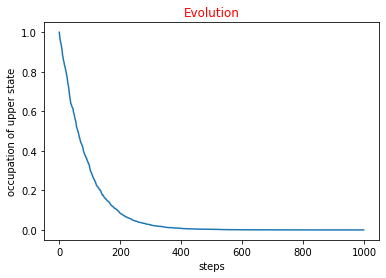

In [2]:
import numpy as np
import matplotlib.pyplot as plt

f = open("2_2_1.txt")
y = [float(i) for i in f]

plt.plot(y)
plt.title("Evolution",c='r')
plt.ylabel("occupation of upper state")
plt.xlabel("steps")

### 微弱光激发情况$\omega = 0.1, \gamma = 0.2, \delta_t = 0.03$

Text(0.5, 0, 'steps')

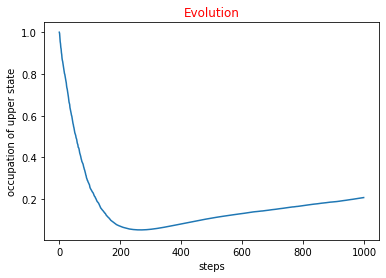

In [3]:
import numpy as np
import matplotlib.pyplot as plt

f = open("2_2_2.txt")
y = [float(i) for i in f]

plt.plot(y)
plt.title("Evolution",c='r')
plt.ylabel("occupation of upper state")
plt.xlabel("steps")

### 中强光激发情况$\omega = 0.2, \gamma = 0.2, \delta_t = 0.03$

Text(0.5, 0, 'steps')

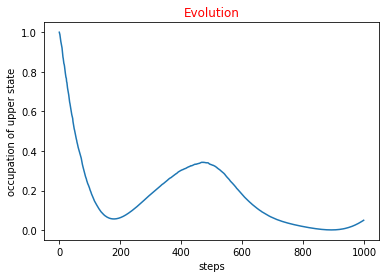

In [4]:
import numpy as np
import matplotlib.pyplot as plt

f = open("2_2_3.txt")
y = [float(i) for i in f]

plt.plot(y)
plt.title("Evolution",c='r')
plt.ylabel("occupation of upper state")
plt.xlabel("steps")

### 较强光激发情况$\omega = 0.5, \gamma = 0.2, \delta_t = 0.03$

Text(0.5, 0, 'steps')

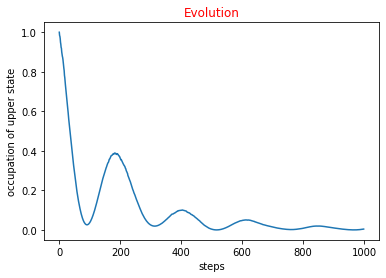

In [5]:
import numpy as np
import matplotlib.pyplot as plt

f = open("2_2_4.txt")
y = [float(i) for i in f]

plt.plot(y)
plt.title("Evolution",c='r')
plt.ylabel("occupation of upper state")
plt.xlabel("steps")

### 极强光激发情况$\omega = 5, \gamma = 0.2, \delta_t = 0.03$

Text(0.5, 0, 'steps')

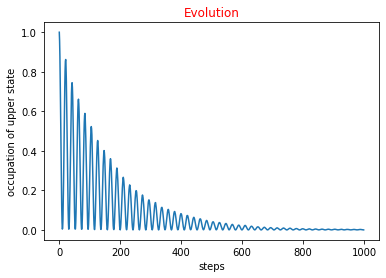

In [6]:
import numpy as np
import matplotlib.pyplot as plt

f = open("2_2_5.txt")
y = [float(i) for i in f]

plt.plot(y)
plt.title("Evolution",c='r')
plt.ylabel("occupation of upper state")
plt.xlabel("steps")

可见，当泵浦光过大或者过小的时候，都会造成末态上态最终为0，所有原子都在下态。而只有一个合适的泵浦值，才能让我们在1000步的模拟中，末态具有一个有限的值。